# Simple noise analysis

Calculate PSD, PGV, PGA and PMS per day and save these parameters as a numpy array.

Create some simple plots.

In [4]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
from obspy import UTCDateTime
import datetime
import scipy
import glob
import sys
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()

sys.path.append('/home/koepflma/project1/Mt-St-Helens')
from functions import *

In [5]:
# # create tuple for multiprocessing
file_list = sorted(glob.glob('/auto/pnwstore1-wd02/PNW2018/UW/2018/*/*SHW*'))
# days = [int(file.split('/')[-1]) for file in file_list]
file_list

['/auto/pnwstore1-wd02/PNW2018/UW/2018/001/SHW.UW.2018.001',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/002/SHW.UW.2018.002',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/003/SHW.UW.2018.003',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/004/SHW.UW.2018.004',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/005/SHW.UW.2018.005',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/006/SHW.UW.2018.006',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/007/SHW.UW.2018.007',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/008/SHW.UW.2018.008',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/009/SHW.UW.2018.009',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/010/SHW.UW.2018.010',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/011/SHW.UW.2018.011',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/012/SHW.UW.2018.012',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/013/SHW.UW.2018.013',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/014/SHW.UW.2018.014',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/015/SHW.UW.2018.015',
 '/auto/pnwstore1-wd02/PNW2018/UW/2018/016/SHW.UW.2018.016',
 '/auto/pnwstore1-wd02/P

In [15]:
# read data to stream
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
year = 2004
jday = 200
try:
    st_r = read_stream(net, sta, cha, year, jday)
except:
    print('Problem during reading mseed to stream: {}-{}'.format(year,day))
st_r

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-07-18T00:00:00.000000Z - 2004-07-19T00:00:00.030000Z | 100.0 Hz, 8640004 samples

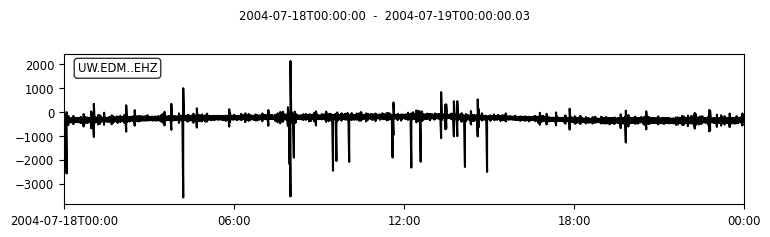

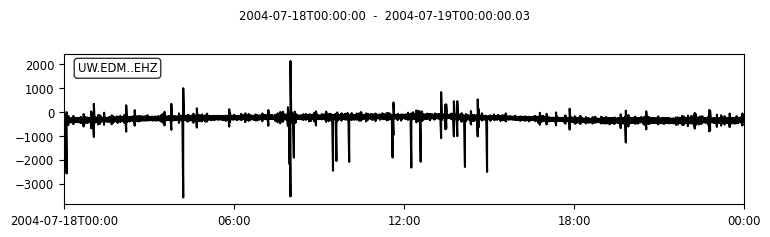

In [16]:
st_r.plot()

In [21]:
st_r[0].stats

         network: UW
         station: EDM
        location: 
         channel: EHZ
       starttime: 2004-07-18T00:00:00.000000Z
         endtime: 2004-07-19T00:00:00.030000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640004
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 21013, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 10758656})

In [36]:
(60*60*24*100)/24-2**18

97856.0

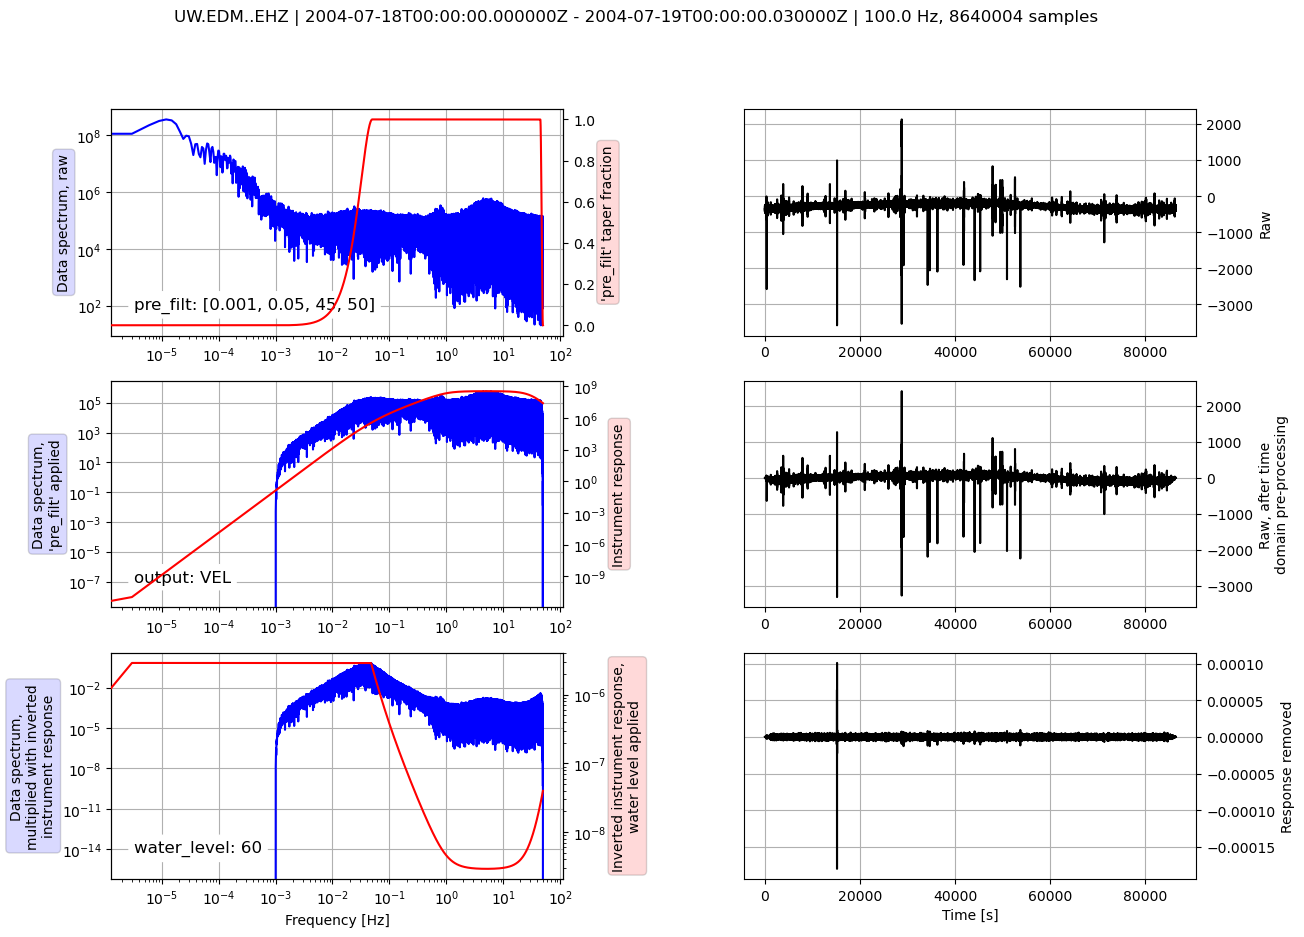

In [17]:
# correct insrument response
inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60
st = st_r.copy()
for tr in st:
    s_time_str = str(tr.stats['starttime']).split('.')[0].replace(':', '-')
    tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                          pre_filt=pre_filt, output="VEL", water_level=water_level,
                          plot=True)
#                           plot='sensor_response_tests/{}__pre_filt{}-{}_{}-{}__water_level{}.png'.format(
#                           s_time_str,
#                           pre_filt[0], pre_filt[1], pre_filt[2], pre_filt[3], water_level))

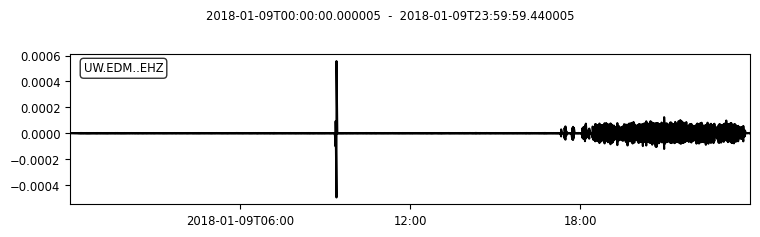

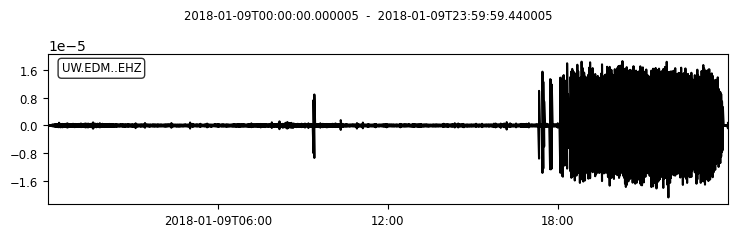

In [10]:
# post-processing
for tr in st:
    tr.plot()
    tr.data = obspy.signal.filter.bandpass(tr, pre_filt[1], pre_filt[2], tr.stats['sampling_rate']) # overvrites stream
    #tr.data = obspy.signal.filter.bandpass(tr, 1, 30, tr.stats['sampling_rate'])
    tr.plot()

In [18]:
# define window length and window overlap
#win_len = 60*60*24 * st[0].stats.sampling_rate # points per day
win_len = 2**16 # number of points in window
win_overlap = 0 # number of overlapping points
min_am = 0.8 # minimal amount of datapoints in sliced trace to take trace into acount

In [19]:
# calculate PSD

Pxx_list =  [] # initialize list
# calculate psd for long enought traces and weight the trace depending on the length of the trace
for tr in st:
    if len(tr.data) >= win_len: # trace is as long or longer as window length
        try:
            # detrend included, tapering included in window type
            Pxx, freqs = matplotlib.mlab.psd(tr.data, NFFT=win_len, noverlap=win_overlap,
                                             window='window_hanning', # vgl windows with screenshot
                                             Fs=st[0].stats.sampling_rate, detrend='linear') # PSD
            Pxx = Pxx[(freqs>1e-1) & (freqs<2e1)] # keep Pxx only between 1e-1 and 2e1 Hz
            Pxx_list.append(Pxx)
            print(Pxx.shape, freqs.shape, len(Pxx_list))
        except:
            print('Long trace, but problems during psd calculations: {}'. format(tr))
    else: # trace is shorter than window length
        print('Short trace: {}'. format(tr))
        
# calculate mean PSD over one day between traces
Pxx = np.mean(Pxx_list, axis=0)
freqs = freqs[(freqs>1e-1) & (freqs<2e1)]
#len(Pxx)

Long trace, but problems during psd calculations: UW.EDM..EHZ | 2004-07-18T00:00:00.000000Z - 2004-07-19T00:00:00.030000Z | 100.0 Hz, 8640004 samples


NameError: name 'freqs' is not defined

In [86]:
# # frequency interpolation
# freqs_out = np.arange(freqs[0], freqs[-1], 0.1)
# f_resfreq = interp1d(freqs, Pxx, axis=0)
# Pxx_res = f_resfreq(freqs_out)

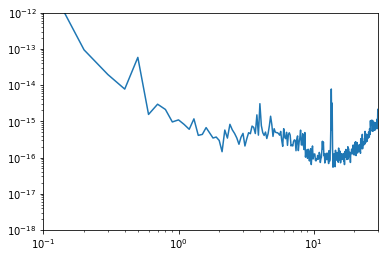

In [87]:
# interpolated 2**19 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs_out, Pxx_res)
ax.set_xlim(1e-1,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

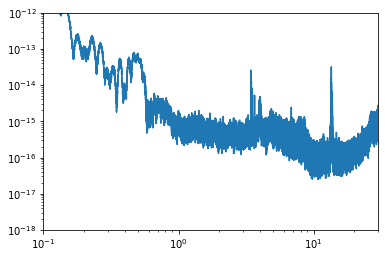

In [69]:
# 2**19 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(1e-1,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

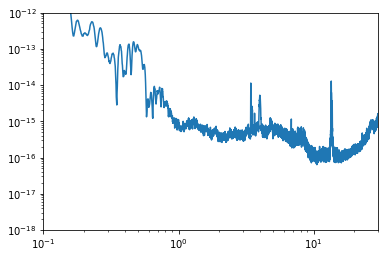

In [92]:
# 2**16 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(1e-1,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

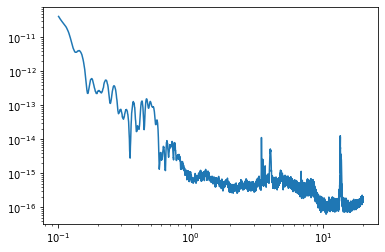

In [171]:
# 2**16 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
# ax.set_xlim(1e-1,3e1)
# ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

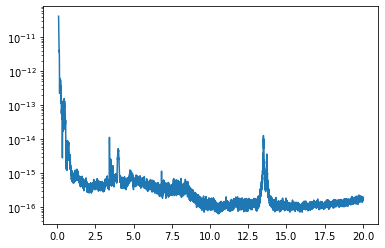

In [173]:
# 2**16 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
# ax.set_xlim(1e-1,3e1)
# ax.set_ylim(1e-18,1e-12)
# ax.set_xscale('log')
ax.set_yscale('log')

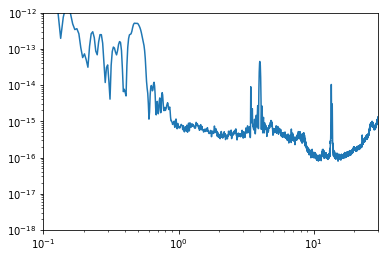

In [69]:
# 2**14 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(1e-1,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

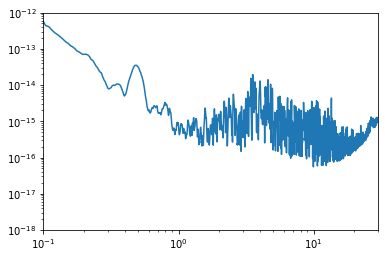

In [33]:
# 2**14 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(1e-1,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

In [65]:
# create array with starttimes for one day (UTCDateTime)
start_times = np.arange(UTCDateTime(st[0].stats['starttime'].date), # midnight of start day (UTCDateTime)
                        UTCDateTime(st[0].stats['starttime'].date)+60*60*24, # midnight of next day (UTCDateTime)
                        (win_len-win_overlap)/st[0].stats['sampling_rate'])[:-1] # time steps in seconds

In [66]:
# TEST Lists
# merge traces within a stream
st_merge = st.copy()
tr_merge = st_merge.merge()[0]

import time
start_tt = time.time()

# initialize lists
rms_list = []
rmes_list = []
pgv_list = []
pga_list = []
    
# loop over starttimes within one day

data_list = [tr_merge.slice(s_time, s_time + 
                            win_len/tr.stats['sampling_rate']).data for s_time in start_times]


for i,s_time in enumerate(start_times):
    
    # try to cut the trace and calculate RMS, RMeS, PGV and PGA
    try:
        tr_cut = tr_merge.slice(s_time, s_time + win_len/tr.stats['sampling_rate']) # win_len in sec
        tr_cut = tr_cut.data

        # if trace is long enought calculate RMS, RMeS, PGV and PGA
        if len(tr_cut) >= min_am*win_len:
            rms = np.sqrt(np.mean(tr_cut**2))
            rmes = np.sqrt(np.median(tr_cut**2))
            pgv = max(abs(tr_cut))

            tr_acc = (tr_cut[1:] - tr_cut[:-1]) / tr.stats['delta']
#             tr_acc = np.gradient(tr_cut, tr.stats['delta'])
            pga = max(abs(tr_acc))
        
        else:
            print('Trace too short: {}'.format(tr_cut))
            
            rms = np.nan
            rmes = np.nan
            pgv = np.nan
            pga = np.nan
            
        # append RMS, RMeS, PGV and PGA to the
        rms_list.append(rms)
        rmes_list.append(rmes)
        pgv_list.append(pgv)
        pga_list.append(pga)   
    
    except:
        print('Problem at starttime: {}'.format(s_time))
        
print(len(rms_list), len(start_times))

# convert lists into arrays
rms_ar = np.array(rms_list)
rmes_ar = np.array(rmes_list)
pgv_ar = np.array(pgv_list)
pga_ar = np.array(pga_list)

stop_tt = time.time()
duration = stop_tt-start_tt
print(duration)

16 16
0.978172779083252


In [6]:
# create multidimensional array
day_ar = np.array([freqs, Pxx, start_times, rms_ar, rmes_ar, pgv_ar, pga_ar])
day_ar.shape

NameError: name 'freqs' is not defined

In [11]:
save_path = 'first_test/{}/{}'.format(year,sta) # path where to save file
save_filename = '{}_{}_{}'.format(year, jday, sta) # file name

if not os.path.exists(save_path): # create folders from save_path if not exists
    os.makedirs(save_path)

In [13]:
save_nparray(save_path, save_filename, day_ar) # save array

2020_103_EDM done


## Load npy

In [38]:
days = range(1,2)
years = [2018]
sta = 'EDM'

merged_list = [(year, day) for year in years for day in days]

t_list = [] # list with dates
Pxx_list = []
rms_list = []
rmes_list = []
pgv_list = []
pga_list = []

for year,day in merged_list:
    
    try: # check if the date exists
        date = UTCDateTime(year=year, julday=day)
        
    except(ValueError):
        print('Date does not exist: {}-{}'.format(year, day))
        continue # if date not exist, go to next itteration
        
    t_list.append(date)
    
    try:
        day_ar = np.load('first_test/{}/{}/{}_{}_{}.npy'.format(year,sta,year,day,sta), allow_pickle=True)
        Pxx_list.append(day_ar[1])
        rms_list.append(day_ar[3])
        rmes_list.append(day_ar[4])
        pgv_list.append(day_ar[5])
        pga_list.append(day_ar[6])
        
    except (FileNotFoundError): # if the file does not exist
        print('File does not exist: {}-{}'.format(year, day))
        Pxx_list.append(np.nan)
        rms_list.append(np.nan)
        rmes_list.append(np.nan)
        pgv_list.append(np.nan)
        pga_list.append(np.nan)
        
print(len(t_list), len(Pxx_list))

# convert lists into arrays
Pxx_ar = np.array(Pxx_list)
rms_ar = np.array(rms_list)
rmes_ar = np.array(rmes_list)
pgv_ar = np.array(pgv_list)
pga_ar = np.array(pga_list)
                  
start_t_list = day_ar[2]
freq = day_ar[0]

1 1


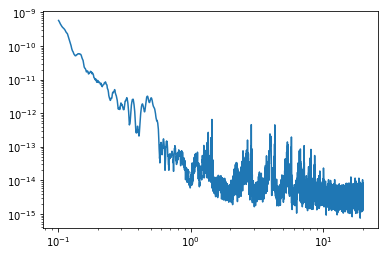

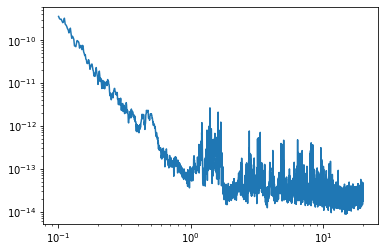

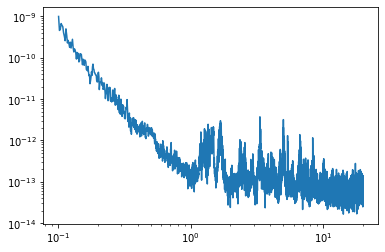

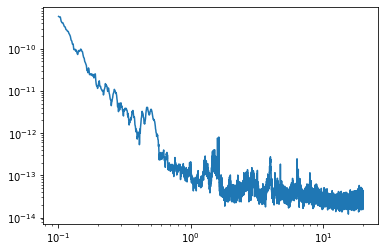

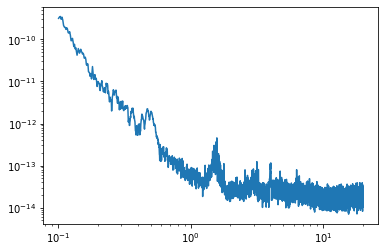

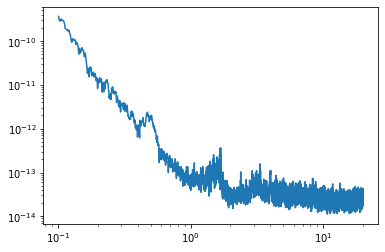

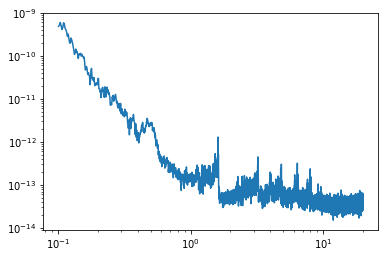

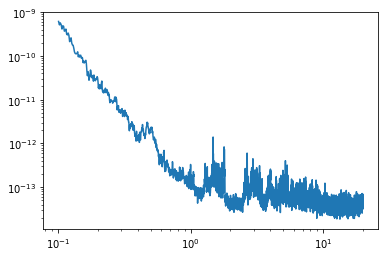

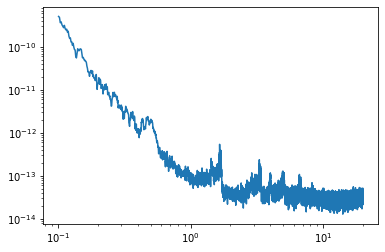

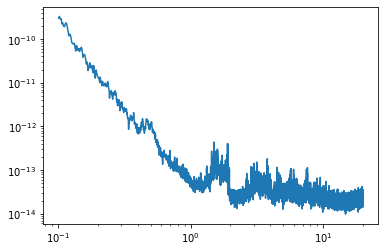

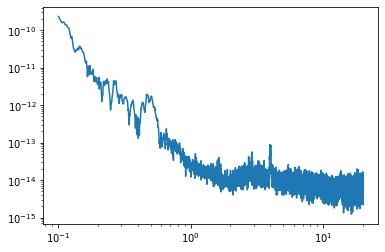

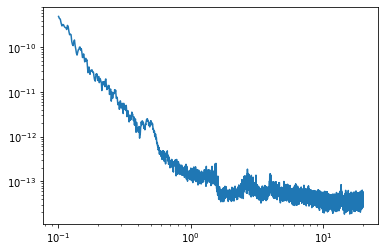

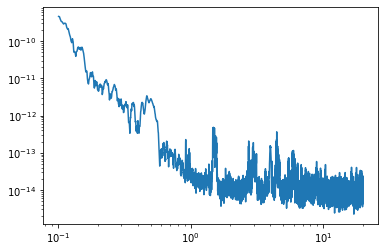

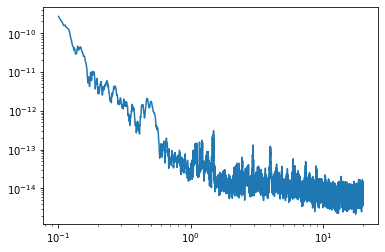

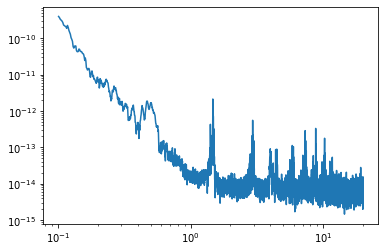

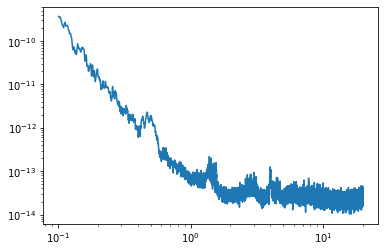

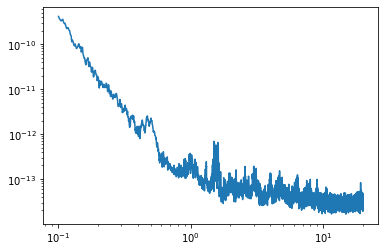

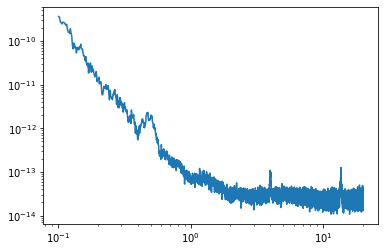

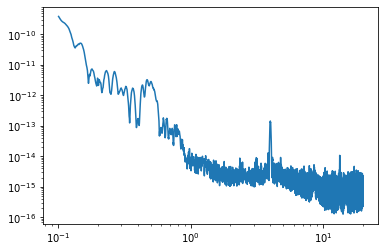

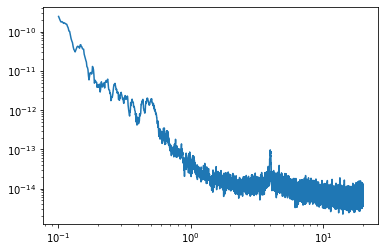

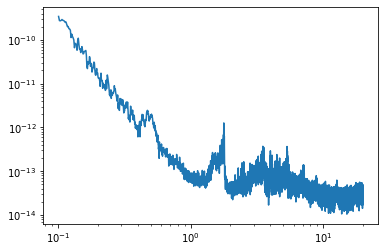

In [32]:
# instrument response removed
for i in range(len(Pxx_ar)):
    fig, ax = plt.subplots()
    ax.plot(freq, Pxx_ar[i])
#     ax.set_xlim(1e-1,3e1)
#     ax.set_ylim(1e-18,1e-11)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.show()

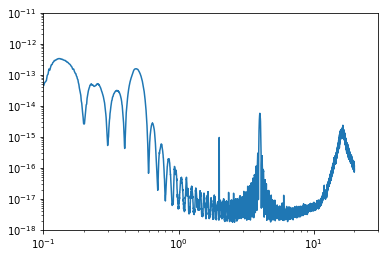

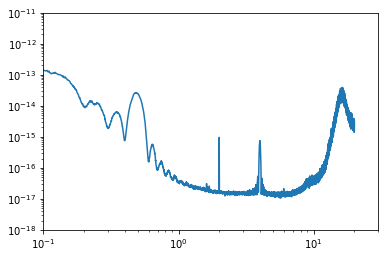

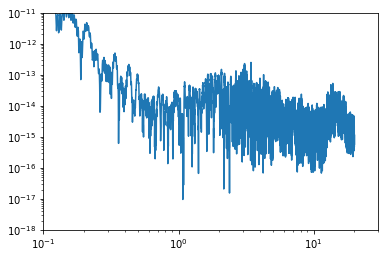

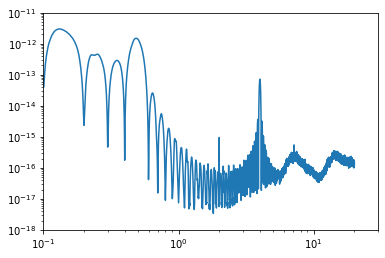

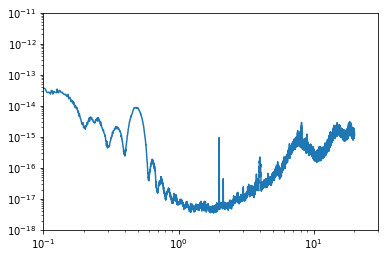

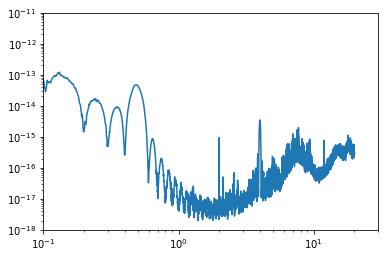

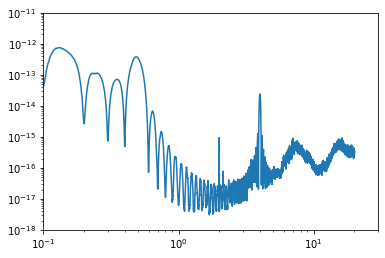

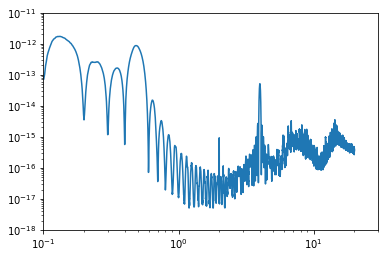

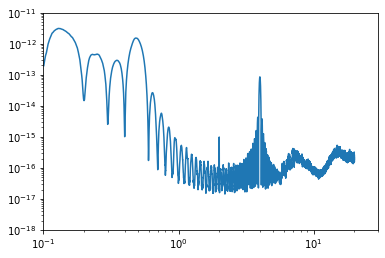

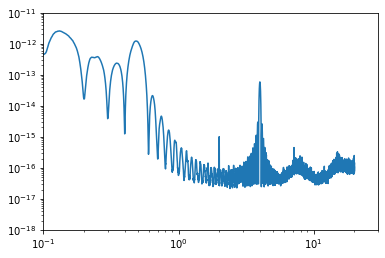

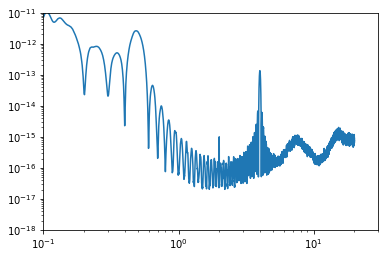

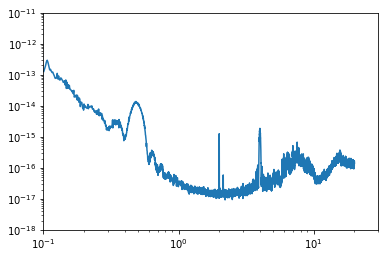

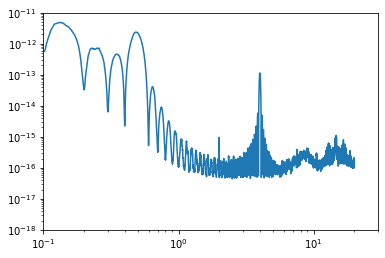

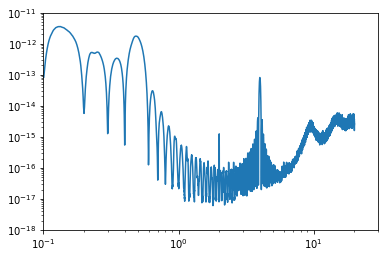

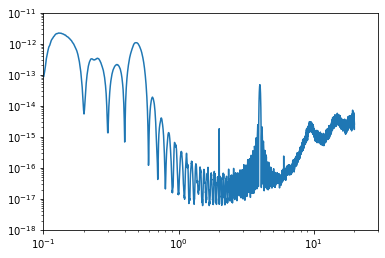

In [28]:
# instrument response removed
for i in range(len(Pxx_ar)):
    fig, ax = plt.subplots()
    ax.plot(freq, Pxx_ar[i])
    ax.set_xlim(1e-1,3e1)
    ax.set_ylim(1e-18,1e-11)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.show()

In [33]:
times, frequencies = np.meshgrid(t_list, freq, sparse=False)
print(times.shape,frequencies.shape)
times # [[t1,t2,...],[t1,t2,...]]
frequencies # [[f1,f1,...],[f2,f2,...]]

(13042, 21) (13042, 21)


array([[ 0.10070801,  0.10070801,  0.10070801, ...,  0.10070801,
         0.10070801,  0.10070801],
       [ 0.10223389,  0.10223389,  0.10223389, ...,  0.10223389,
         0.10223389,  0.10223389],
       [ 0.10375977,  0.10375977,  0.10375977, ...,  0.10375977,
         0.10375977,  0.10375977],
       ...,
       [19.99664307, 19.99664307, 19.99664307, ..., 19.99664307,
        19.99664307, 19.99664307],
       [19.99816895, 19.99816895, 19.99816895, ..., 19.99816895,
        19.99816895, 19.99816895],
       [19.99969482, 19.99969482, 19.99969482, ..., 19.99969482,
        19.99969482, 19.99969482]])

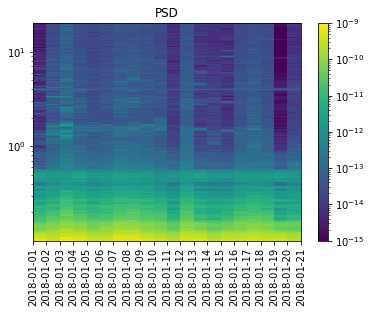

In [34]:
fig, ax = plt.subplots()
#plt.imshow(np.log10(Pxx_ar[:,300:10000]), aspect='auto')
# pmc = plt.pcolormesh(times, frequencies, np.log10(np.transpose(Pxx_ar)), vmin=-15, vmax=-9.5,
#                     norm=colors.LogNorm(vmin,vmax))

vmin = 1e-15
vmax = 1e-9
pmc = plt.pcolormesh(times, frequencies, np.transpose(Pxx_ar), vmin=vmin, vmax=vmax,
                    norm=colors.LogNorm(vmin,vmax))
ax.set_yscale('log')
# ax.set_xticks(range(0,len(freq),1000))
# ax.set_xticklabels([freq[ff] for ff in range(0,len(freq),1000)])

ax.set_xticks(range(int(ax.get_xlim()[0]),int(ax.get_xlim()[1]),int(60*60*24-1)))
ax.set_xticklabels([day_d.date for day_d in t_list], rotation = 90)
# ax.set_xticklabels(datetime.datetime.fromtimestamp(ax.get_xlim()*1e-9).strftime('%Y-%m-%d'))

ax.set_title('PSD')
plt.colorbar(pmc)
plt.show()

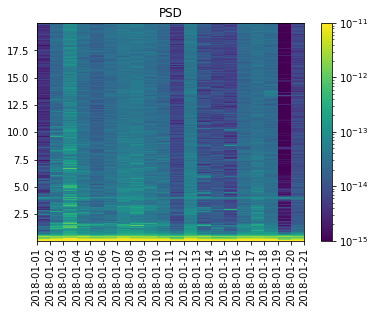

In [19]:
fig, ax = plt.subplots()
#plt.imshow(np.log10(Pxx_ar[:,300:10000]), aspect='auto')
# pmc = plt.pcolormesh(times, frequencies, np.log10(np.transpose(Pxx_ar)), vmin=-15, vmax=-9.5,
#                     norm=colors.LogNorm(vmin,vmax))
vmin = 1e-15
vmax = 1e-11
pmc = plt.pcolormesh(times, frequencies, np.transpose(Pxx_ar), vmin=vmin, vmax=vmax,
                    norm=colors.LogNorm(vmin,vmax))

#ax.set_yscale('log')
ax.set_xticks(range(int(ax.get_xlim()[0]),int(ax.get_xlim()[1]),int(60*60*24-1)))
ax.set_xticklabels([day_d.date for day_d in t_list], rotation = 90)
# ax.set_xticklabels(datetime.datetime.fromtimestamp(ax.get_xlim()*1e-9).strftime('%Y-%m-%d'))

ax.set_title('PSD')

plt.colorbar(pmc)
plt.show()

In [ ]:
mittelwert von jedem zeitfenster uber alle tage mit nachbarn vergleichen

In [ ]:
fig, ax = plt.subplots()
plt.imshow(np.log10(Pxx_ar[:,100:1000]), aspect='auto')
#ax.set_xscale('log')
# ax.set_xticks(range(0,len(freq),1000))
# ax.set_xticklabels([freq[ff] for ff in range(0,len(freq),1000)])

ax.set_yticks(range(0,len(t_list)))
ax.set_yticklabels([day_d.date for day_d in t_list])
#pmc = colors.LogNorm(vmin=Pxx_ar[:,:100].min(), vmax=Pxx_ar[:,:100].max())
plt.colorbar()
plt.show()

In [324]:
len(range(int(ax.get_xlim()[0]),int(ax.get_xlim()[1]),int(60*60*24-1)))

21

In [281]:
t_datetime, t_day = np.meshgrid(t_list, start_t_list, sparse=False)
print(t_datetime.shape,t_day.shape)
t_datetime # [[t1,t2,...],[t1,t2,...]]
t_day # [[f1,f1,...],[f2,f2,...]]

(131, 21) (131, 21)


array([[UTCDateTime(2018, 1, 21, 0, 0), UTCDateTime(2018, 1, 21, 0, 0),
        UTCDateTime(2018, 1, 21, 0, 0), ...,
        UTCDateTime(2018, 1, 21, 0, 0), UTCDateTime(2018, 1, 21, 0, 0),
        UTCDateTime(2018, 1, 21, 0, 0)],
       [UTCDateTime(2018, 1, 21, 0, 10, 55, 360000),
        UTCDateTime(2018, 1, 21, 0, 10, 55, 360000),
        UTCDateTime(2018, 1, 21, 0, 10, 55, 360000), ...,
        UTCDateTime(2018, 1, 21, 0, 10, 55, 360000),
        UTCDateTime(2018, 1, 21, 0, 10, 55, 360000),
        UTCDateTime(2018, 1, 21, 0, 10, 55, 360000)],
       [UTCDateTime(2018, 1, 21, 0, 21, 50, 720000),
        UTCDateTime(2018, 1, 21, 0, 21, 50, 720000),
        UTCDateTime(2018, 1, 21, 0, 21, 50, 720000), ...,
        UTCDateTime(2018, 1, 21, 0, 21, 50, 720000),
        UTCDateTime(2018, 1, 21, 0, 21, 50, 720000),
        UTCDateTime(2018, 1, 21, 0, 21, 50, 720000)],
       ...,
       [UTCDateTime(2018, 1, 21, 23, 18, 6, 80000),
        UTCDateTime(2018, 1, 21, 23, 18, 6, 80000),
      

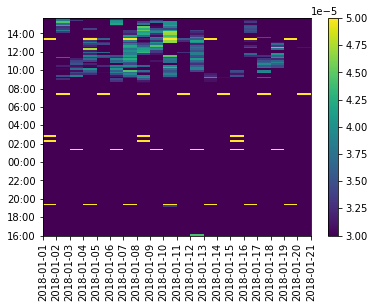

In [359]:
fig, ax = plt.subplots()
pmc = plt.pcolormesh(t_datetime, t_day, np.transpose(rms_ar), vmin=5e-5, vmax=3e-5)

ax.set_xticks(range(int(ax.get_xlim()[0]),int(ax.get_xlim()[1]),int(60*60*24-1)))
ax.set_xticklabels([day_d.strftime("%Y-%m-%d") for day_d in t_list], rotation = 90)
#ax.set_xticklabels([day_d.strftime("%Y-%m-%d") for day_d in t_list], rotation = 90) # date
nanos = range(int(ax.get_ylim()[0]),int(ax.get_ylim()[1]),int(2*60*60))
ax.set_yticks(nanos)
ax.set_yticklabels([datetime.datetime.fromtimestamp(nn).strftime("%H:%M") for nn in nanos]) # time
# ax.set_yticklabels([tt.strftime("%H:%M:%S") for tt in start_t_list]) # time

plt.colorbar(pmc)
plt.show()

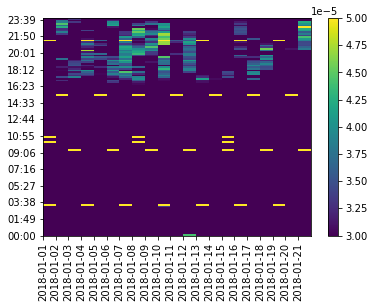

In [394]:
fig, ax = plt.subplots()
pmc = plt.pcolormesh(np.transpose(rms_ar), vmin=5e-5, vmax=3e-5)

ax.set_xticks(range(0,len(t_list),1))
ax.set_xticklabels([day_d.strftime("%Y-%m-%d") for day_d in t_list], rotation = 90)

dtimes = range(0,len(start_t_list),10)
ax.set_yticks(dtimes)
ax.set_yticklabels([start_t_list[tt].strftime("%H:%M") for tt in dtimes]) # time

plt.colorbar(pmc)
plt.show()

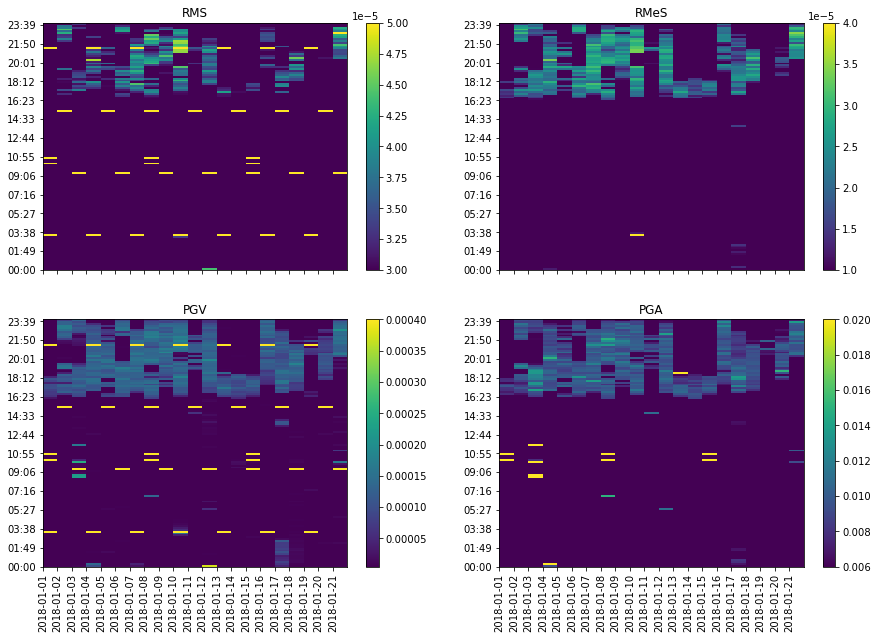

In [5]:
# original
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 10), sharex=True)
titles = ['RMS', 'RMeS', 'PGV', 'PGA']
vmins = [5e-5, 1e-5, 5e-6, 6e-3]
vmaxs = [3e-5, 4e-5, 4e-4, 2e-2]

for ax, matrix, title, vmin, vmax in zip((ax1,ax2,ax3,ax4),(rms_ar,rmes_ar,pgv_ar,pga_ar), titles, vmins, vmaxs):
    pcm = ax.pcolormesh(np.transpose(matrix), vmin=vmin, vmax=vmax)
    ax.set_title('{}'.format(title))
    ax.set_xticks(range(0,len(t_list),1))
    ax.set_xticklabels([day_d.strftime("%Y-%m-%d") for day_d in t_list], rotation = 90)

    dtimes = range(0,len(start_t_list),10)
    ax.set_yticks(dtimes)
    ax.set_yticklabels([start_t_list[tt].strftime("%H:%M") for tt in dtimes]) # time
    
    dtimes = range(0,len(start_t_list),10)
    ax.set_yticks(dtimes)
    ax.set_yticklabels([start_t_list[tt].strftime("%H:%M") for tt in dtimes]) # time

    fig.colorbar(pcm, ax=ax)
#plt.show()

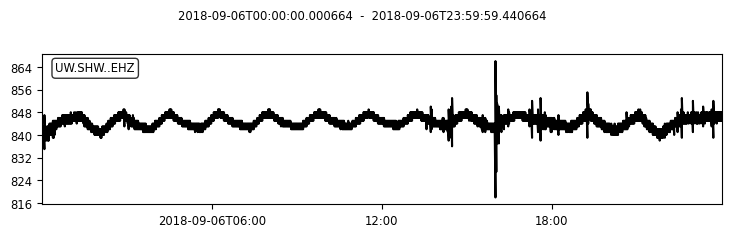

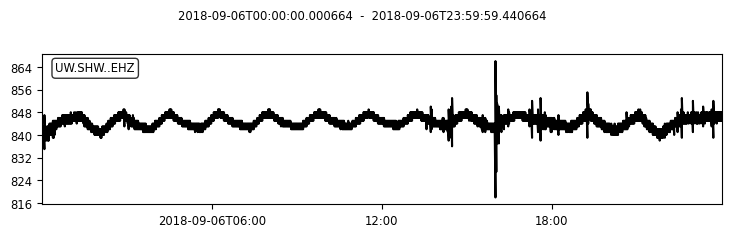

In [59]:
net = 'UW'
sta = 'SHW'
cha = 'EHZ'
jday = 249
year = 2018
st_long = obspy.Stream()
st_r = read_stream(net, sta, cha, year, jday)
st_r

st_r.slice(st_r[0].stats.starttime)

st_r.plot()

1 Trace(s) in Stream:
UW.EDM..EHZ | 2018-01-01T00:00:00.000416Z - 2018-01-01T23:59:59.440416Z | 100.0 Hz, 8639945 samples

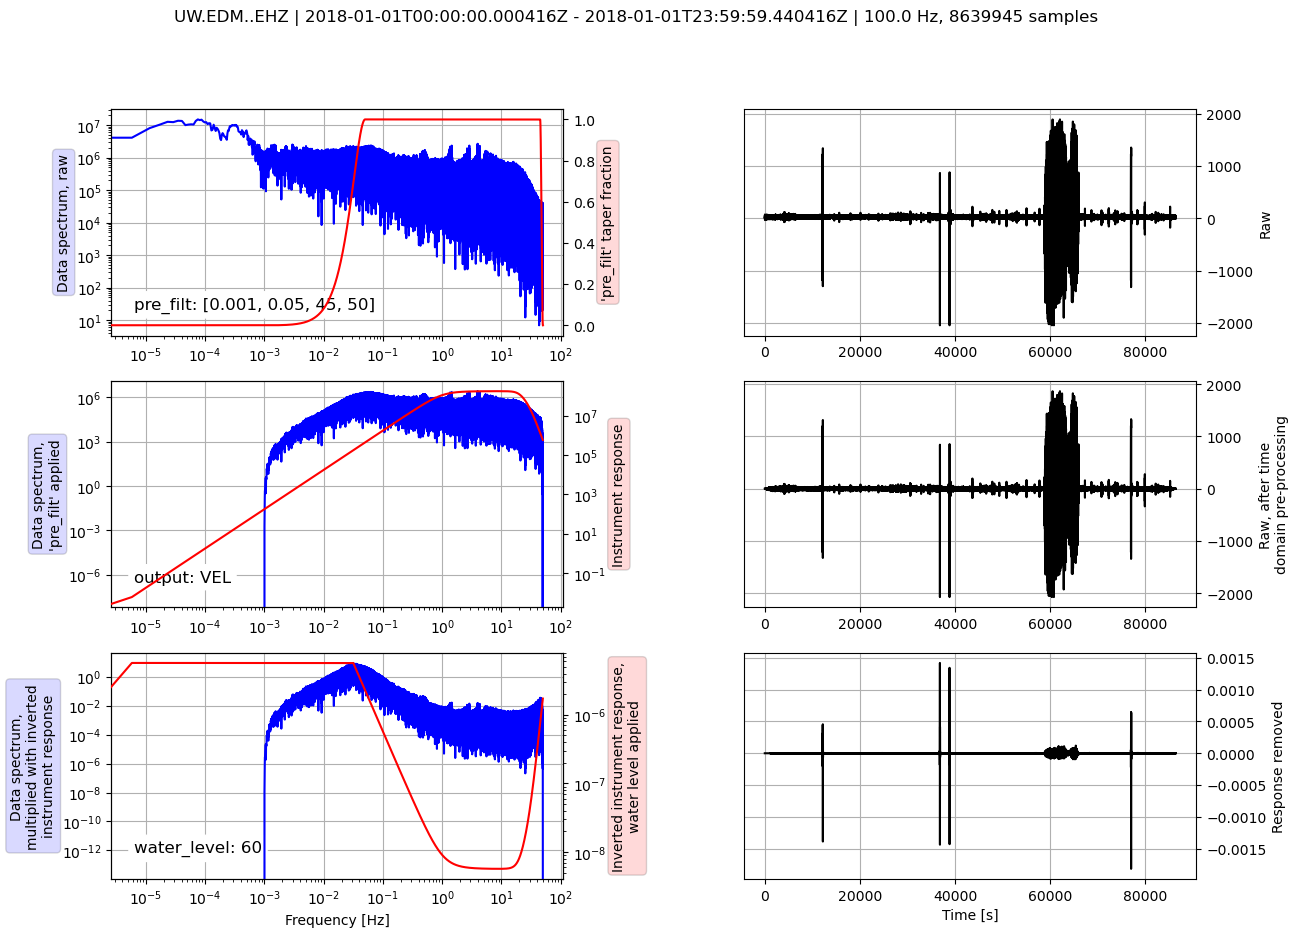

In [79]:
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
jday = 1
year = 2018
st_long = obspy.Stream()
st_r = read_stream(net, sta, cha, year, jday)
st_r

inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60
st = st_r.copy()
for tr in st:
    s_time_str = str(tr.stats['starttime']).split('.')[0].replace(':', '-')
    tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                          pre_filt=pre_filt, output="VEL", water_level=water_level,
                          plot=True)

st.slice(st_r[0].stats.starttime)

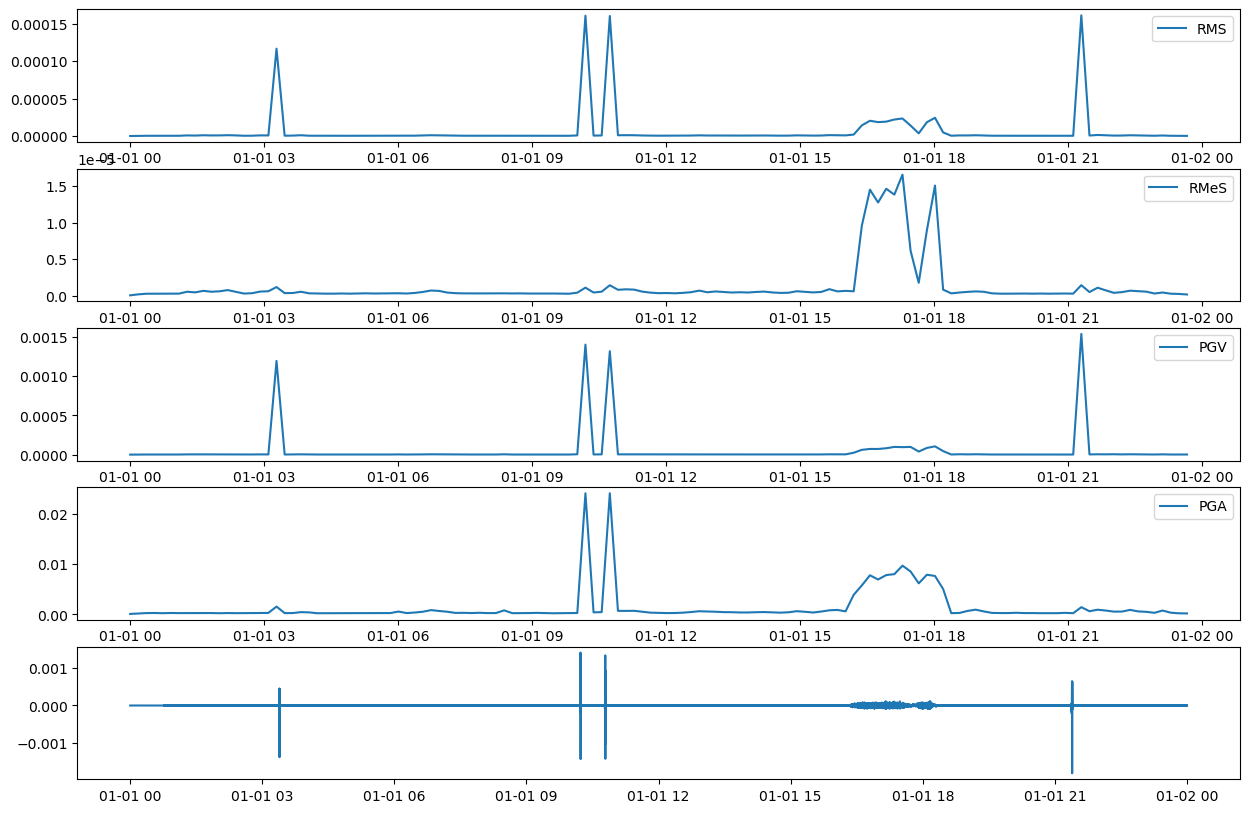

In [81]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15, 10))
ax1.plot([i.datetime for i in day_ar[2]], day_ar[3], label='RMS')
ax2.plot([i.datetime for i in day_ar[2]], day_ar[4], label='RMeS')
ax3.plot([i.datetime for i in day_ar[2]], day_ar[5], label='PGV')
ax4.plot([i.datetime for i in day_ar[2]], day_ar[6], label='PGA')
for i, tr in enumerate(st_r):
    ax5.plot(st[i].times('matplotlib'), st[i].data, "C{}".format(i))
    ax5.xaxis_date()

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

## working with pd

In [86]:
days = range(1,4)
years = [2018]
sta = 'EDM'

merged_list = [(year, day) for year in years for day in days]

t_list = [] # list with dates
Pxx_list = []
rms_list = []
rmes_list = []
pgv_list = []
pga_list = []

df = pd.DataFrame()

for year,day in merged_list:
    
    try:
        day_ar = np.load('first_test/{}/{}/{}_{}_{}.npy'.format(year,sta,year,day,sta), allow_pickle=True)
        
        Pxx_list.append(day_ar[1])
        
        t_list.append([t_w for t_w in day_ar[2]])
        rms_list.append([rms for rms in day_ar[3]])
        rmes_list.append(day_ar[4])
        pgv_list.append(day_ar[5])
        pga_list.append(day_ar[6])
        
        
    except (FileNotFoundError): # if the file does not exist
        print('File does not exist: {}-{}'.format(year, day))
        
        Pxx_list.append(np.nan)
        
        date_times = [datetime.datetime.combine(UTCDateTime(year=year, julday=day).date, t_w.time) 
                      for t_w in day_ar[2]]
        t_list.append(date_times)
        rms_list.append(np.nan)
        rmes_list.append(np.nan)
        pgv_list.append(np.nan)
        pga_list.append(np.nan)
        
    # lists to DataFrame

df['UTC'] = t_list[0]
df['RMS'] = rms_list[0]
                  
freq = day_ar[0]

In [87]:
df

,UTC,RMS
0,2018-01-01T00:00:00.000000Z,1.028882e-07
1,2018-01-01T00:10:55.360000Z,2.731302e-07
2,2018-01-01T00:21:50.720000Z,3.978603e-07
3,2018-01-01T00:32:46.080000Z,3.967407e-07
4,2018-01-01T00:43:41.440000Z,4.191699e-07
...,...,...
126,2018-01-01T22:56:15.360000Z,4.495009e-07
127,2018-01-01T23:07:10.720000Z,7.752433e-07
128,2018-01-01T23:18:06.080000Z,4.060968e-07
129,2018-01-01T23:29:01.440000Z,3.562269e-07


In [85]:
t_list[2]

array([UTCDateTime(2018, 1, 3, 0, 0),
       UTCDateTime(2018, 1, 3, 0, 10, 55, 360000),
       UTCDateTime(2018, 1, 3, 0, 21, 50, 720000),
       UTCDateTime(2018, 1, 3, 0, 32, 46, 80000),
       UTCDateTime(2018, 1, 3, 0, 43, 41, 440000),
       UTCDateTime(2018, 1, 3, 0, 54, 36, 800000),
       UTCDateTime(2018, 1, 3, 1, 5, 32, 160000),
       UTCDateTime(2018, 1, 3, 1, 16, 27, 520000),
       UTCDateTime(2018, 1, 3, 1, 27, 22, 880000),
       UTCDateTime(2018, 1, 3, 1, 38, 18, 240000),
       UTCDateTime(2018, 1, 3, 1, 49, 13, 600000),
       UTCDateTime(2018, 1, 3, 2, 0, 8, 960000),
       UTCDateTime(2018, 1, 3, 2, 11, 4, 320000),
       UTCDateTime(2018, 1, 3, 2, 21, 59, 680000),
       UTCDateTime(2018, 1, 3, 2, 32, 55, 40000),
       UTCDateTime(2018, 1, 3, 2, 43, 50, 400000),
       UTCDateTime(2018, 1, 3, 2, 54, 45, 760000),
       UTCDateTime(2018, 1, 3, 3, 5, 41, 120000),
       UTCDateTime(2018, 1, 3, 3, 16, 36, 480000),
       UTCDateTime(2018, 1, 3, 3, 27, 31, 840000),


In [45]:
[datetime.datetime.combine(UTCDateTime(year=year, julday=day).date, t_w.time) for t_w in day_ar[2]]

[datetime.datetime(2018, 1, 21, 0, 0),
 datetime.datetime(2018, 1, 21, 0, 10, 55, 360000),
 datetime.datetime(2018, 1, 21, 0, 21, 50, 720000),
 datetime.datetime(2018, 1, 21, 0, 32, 46, 80000),
 datetime.datetime(2018, 1, 21, 0, 43, 41, 440000),
 datetime.datetime(2018, 1, 21, 0, 54, 36, 800000),
 datetime.datetime(2018, 1, 21, 1, 5, 32, 160000),
 datetime.datetime(2018, 1, 21, 1, 16, 27, 520000),
 datetime.datetime(2018, 1, 21, 1, 27, 22, 880000),
 datetime.datetime(2018, 1, 21, 1, 38, 18, 240000),
 datetime.datetime(2018, 1, 21, 1, 49, 13, 600000),
 datetime.datetime(2018, 1, 21, 2, 0, 8, 960000),
 datetime.datetime(2018, 1, 21, 2, 11, 4, 320000),
 datetime.datetime(2018, 1, 21, 2, 21, 59, 680000),
 datetime.datetime(2018, 1, 21, 2, 32, 55, 40000),
 datetime.datetime(2018, 1, 21, 2, 43, 50, 400000),
 datetime.datetime(2018, 1, 21, 2, 54, 45, 760000),
 datetime.datetime(2018, 1, 21, 3, 5, 41, 120000),
 datetime.datetime(2018, 1, 21, 3, 16, 36, 480000),
 datetime.datetime(2018, 1, 21, 

In [41]:
datetime.datetime.combine(UTCDateTime(year=year, julday=day).date, [t_w.time for t_w in day_ar[2]])

TypeError: combine() argument 2 must be datetime.time, not list

In [5]:
UTCDateTime(year=2004, julday=366, hour=7)

2004-12-31T07:00:00.000000Z

In [11]:
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
year = 2004

st_long = obspy.Stream()
for jday in range(247,248):
    st_r = read_stream(net, sta, cha, year, jday)
    st_long += st_r
st_long

12 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-03T00:00:00.009900Z - 2004-09-03T14:06:29.979900Z | 100.0 Hz, 5078998 samples
UW.EDM..EHZ | 2004-09-03T14:06:30.000900Z - 2004-09-03T15:56:30.000900Z | 100.0 Hz, 660001 samples
UW.EDM..EHZ | 2004-09-03T15:56:30.020900Z - 2004-09-03T16:51:40.010900Z | 100.0 Hz, 331000 samples
UW.EDM..EHZ | 2004-09-03T16:51:40.030900Z - 2004-09-03T17:45:10.020900Z | 100.0 Hz, 321000 samples
UW.EDM..EHZ | 2004-09-03T17:45:10.041000Z - 2004-09-03T18:38:40.031000Z | 100.0 Hz, 321000 samples
UW.EDM..EHZ | 2004-09-03T18:38:40.051000Z - 2004-09-03T19:32:30.041000Z | 100.0 Hz, 323000 samples
UW.EDM..EHZ | 2004-09-03T19:32:30.060900Z - 2004-09-03T20:26:20.050900Z | 100.0 Hz, 323000 samples
UW.EDM..EHZ | 2004-09-03T20:26:20.070900Z - 2004-09-03T21:20:30.060900Z | 100.0 Hz, 325000 samples
UW.EDM..EHZ | 2004-09-03T21:20:30.081000Z - 2004-09-03T22:15:00.071000Z | 100.0 Hz, 327000 samples
UW.EDM..EHZ | 2004-09-03T22:15:00.091000Z - 2004-09-03T23:09:30.081000Z | 100.0 Hz, 3

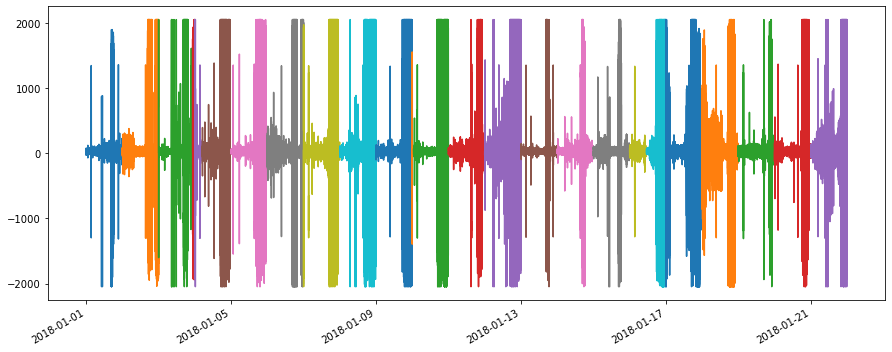

In [55]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
for i in range(len(st_long)):
    ax.plot(st_long[i].times("matplotlib"), st_long[i].data, "C{}".format(i))
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

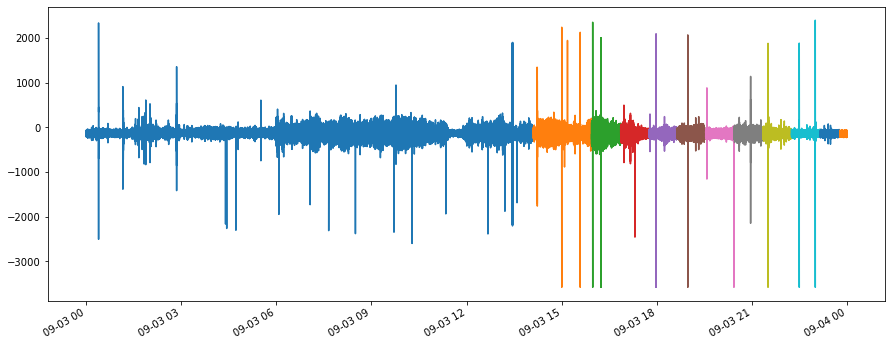

In [12]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
for i in range(len(st_long)):
    ax.plot(st_long[i].times("matplotlib"), st_long[i].data, "C{}".format(i))
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

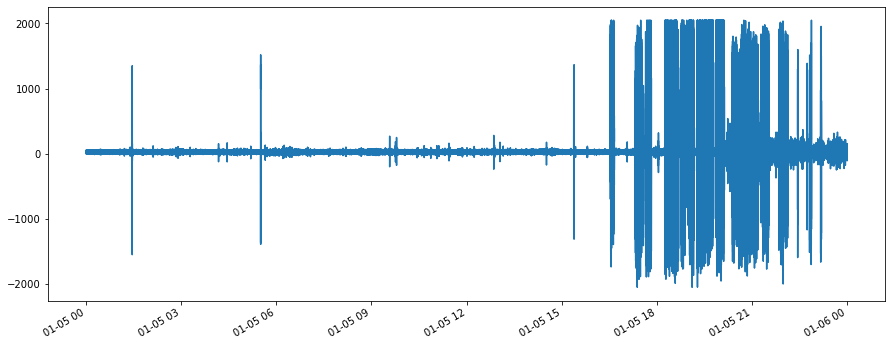

In [12]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
for i in range(len(st_r)):
    ax.plot(st_r[i].times("matplotlib"), st_r[i].data, "C{}".format(i))
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

Text(0.04, 0.5, 'counts')

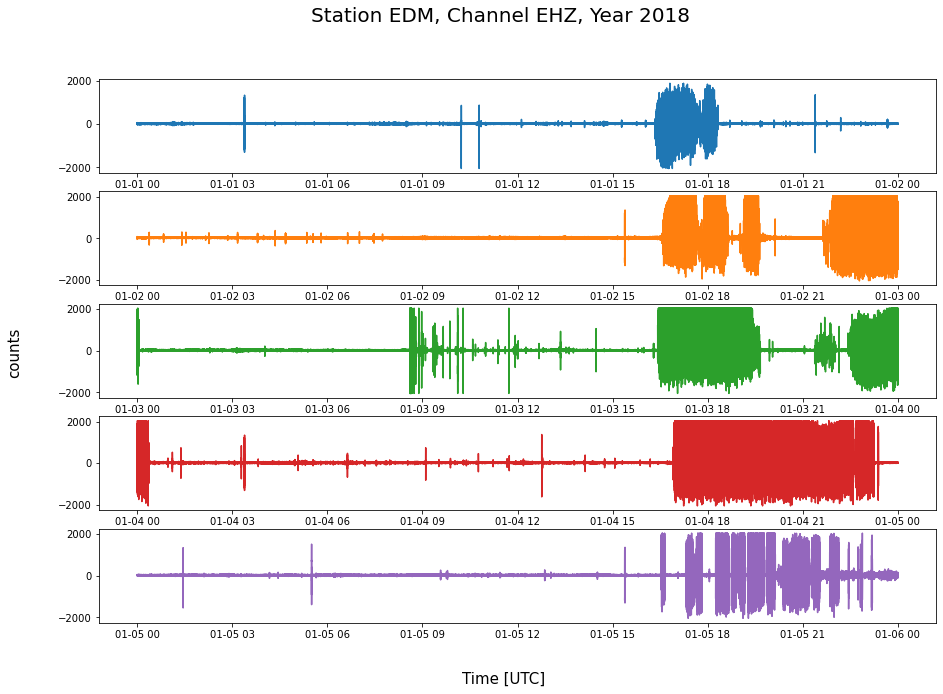

In [27]:
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
year = 2018
jdays = range(1,6)

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 10), sharex=True)
fig, ax = plt.subplots(len(jdays), figsize=(15, 10))

for i,jday in enumerate(jdays):
    st_r = read_stream(net, sta, cha, year, jday)
    st_m = st_r.copy().merge()
    ax[i].plot(st_m[0].times("matplotlib"), st_m[0].data, "C{}".format(i))
    ax[i].xaxis_date()
fig.suptitle('Station EDM, Channel EHZ, Year 2018 ', fontsize=20)
fig.text(0.5, 0.04, 'Time [UTC]', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'counts', va='center', rotation='vertical', fontsize=15)
#fig.tight_layout()

Text(0.04, 0.5, 'counts')

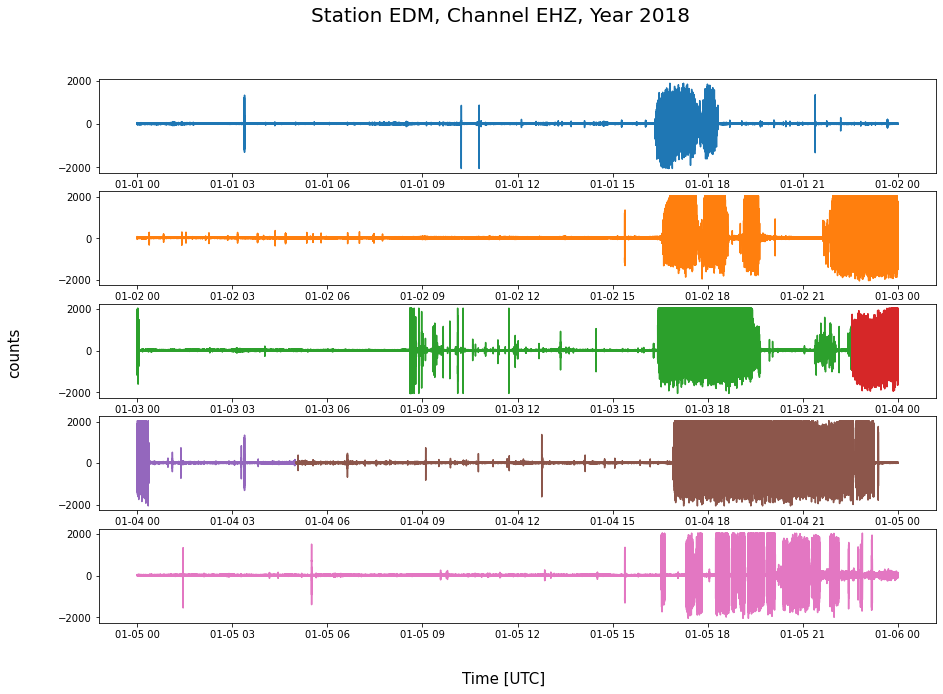

In [30]:
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
year = 2018
jdays = range(1,6)

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 10), sharex=True)
fig, ax = plt.subplots(len(jdays), figsize=(15, 10))

i = 0
for j,jday in enumerate(jdays):
    st_r = read_stream(net, sta, cha, year, jday)
    for trx in range(len(st_r)):
        ax[j].plot(st_r[trx].times("matplotlib"), st_r[trx].data, "C{}".format(i))
        ax[j].xaxis_date()
        i += 1
fig.suptitle('Station EDM, Channel EHZ, Year 2018 ', fontsize=20)
fig.text(0.5, 0.04, 'Time [UTC]', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'counts', va='center', rotation='vertical', fontsize=15)
#fig.tight_layout()

In [345]:
[datetime.datetime.fromtimestamp(nn).strftime("%H:%M") for nn in nanos]

['16:00',
 '18:00',
 '20:00',
 '22:00',
 '00:00',
 '02:00',
 '04:00',
 '06:00',
 '08:00',
 '10:00',
 '12:00',
 '14:00']

In [355]:
print(rms_ar.shape,len(start_t_list))

(21, 131) 131


In [13]:
st_r[0].times("matplotlib")

array([17536.        , 17536.00000012, 17536.00000023, ...,
       17536.9999934 , 17536.99999352, 17536.99999363])

# TESTS

In [ ]:
# time a function -> do not print because timeit iterrate several time
%timeit rms_list = [max(abs((tr_cut[1:] - tr_cut[:-1]) / tr.stats['delta'])) if len(tr_cut) >= min_am else np.nan for tr_cut in data_list]

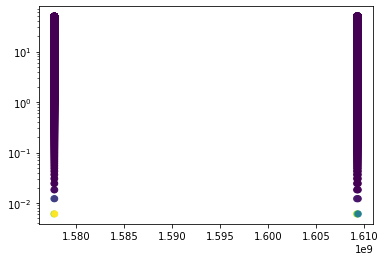

In [34]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(xx, yy, c=Pxx_ar)

In [11]:
# # TEST arrays
# # merge traces within a stream
# st_merge = st.copy()
# tr_merge = st_merge.merge()[0]

# import time
# start_tt = time.time()

# # initialize lists
# # rms_list = []
# # rmes_list = []
# # pgv_list = []
# # pga_list = []
# rms_list = np.full(len(start_times), np.nan)
# rmes_list = np.full(len(start_times), np.nan)
# pgv_list = np.full(len(start_times), np.nan)
# pga_list = np.full(len(start_times), np.nan)
    
# # loop over starttimes within one day
# for i,s_time in enumerate(start_times):
    
#     # try to cut the trace and calculate RMS, RMeS, PGV and PGA
#     try:
#         tr_cut = tr_merge.slice(s_time, s_time + win_len/tr.stats['sampling_rate']) # win_len in sec
#         tr_cut = tr_cut.data

#         # if trace is long enought calculate RMS, RMeS, PGV and PGA
#         if len(tr_cut.data) >= min_am:
#             rms = np.sqrt(np.mean(tr_cut**2))
#             rmes = np.sqrt(np.median(tr_cut**2))
#             pgv = max(abs(tr_cut))

#             tr_acc = (tr_cut.copy()[:-1] - tr_cut.copy()[1:]) /tr.stats['delta']
#             pga = max(abs(tr_acc))
        
#         else:
#             print('Trace too short: {}'.format(tr_cut))
            
# #             rms = np.nan
# #             rmes = np.nan
# #             pgv = np.nan
# #             pga = np.nan
            
#         # append RMS, RMeS, PGV and PGA to the
# #         rms_list.append(rms)
# #         rmes_list.append(rmes)
# #         pgv_list.append(pgv)
# #         pga_list.append(pga)  
#         rms_list[i] = rms
#         rmes_list[i] = rmes
#         pgv_list[i] = pgv
#         pga_list[i] = pga 
    
#     except:
#         print('Problem at starttime: {}'.format(s_time))
        
# print(len(rms_list), len(start_times))

# stop_tt = time.time()
# duration = stop_tt-start_tt
# print(duration)

527 527
18.027713298797607


In [42]:
# # TEST Lists
# # merge traces within a stream
# st_merge = st.copy()
# tr_merge = st_merge.merge()[0]

# import time
# start_tt = time.time()

# # loop over starttimes within one day

# data_list = [tr_merge.slice(s_time, 
#                             s_time + 
#                             win_len/tr.stats['sampling_rate']).data for s_time in start_times]
# rms_list = [np.sqrt(np.mean(tr_cut**2)) if len(tr_cut) >= min_am else np.nan for tr_cut in data_list]
# rmes_list = [np.sqrt(np.median(tr_cut**2)) if len(tr_cut) >= min_am else np.nan for tr_cut in data_list]
# pgv_list = [max(abs(tr_cut)) if len(tr_cut) >= min_am else np.nan for tr_cut in data_list]
# rms_list = [max(abs((tr_cut[1:] - tr_cut[:-1]) / tr.stats['delta'])) if len(tr_cut) >= min_am else np.nan for tr_cut in data_list]

# rms_ar = np.array(rms_list)
# rmes_ar = np.array(rmes_list)
# pgv_ar = np.array(pgv_list)
# pga_ar = np.array(pga_list)

# stop_tt = time.time()
# duration = stop_tt-start_tt
# print(duration)

17.876917839050293


In [21]:
# # load array from npy file
# test_load= np.load('{}/2020_365_EDM.npy'.format(save_path, save_filename), allow_pickle=True)
# test_load

array([array([0.00000000e+00, 6.10351562e-03, 1.22070312e-02, ...,
              4.99877930e+01, 4.99938965e+01, 5.00000000e+01])    ,
       array([8.91309430e-15, 3.36307856e-13, 3.93170389e-11, ...,
              2.68608435e-23, 3.84130091e-24, 2.07040940e-25])    ,
       array([UTCDateTime(2020, 12, 30, 0, 0),
              UTCDateTime(2020, 12, 30, 0, 2, 43, 840000),
              UTCDateTime(2020, 12, 30, 0, 5, 27, 680000),
              UTCDateTime(2020, 12, 30, 0, 8, 11, 520000),
              UTCDateTime(2020, 12, 30, 0, 10, 55, 360000),
              UTCDateTime(2020, 12, 30, 0, 13, 39, 200000),
              UTCDateTime(2020, 12, 30, 0, 16, 23, 40000),
              UTCDateTime(2020, 12, 30, 0, 19, 6, 880000),
              UTCDateTime(2020, 12, 30, 0, 21, 50, 720000),
              UTCDateTime(2020, 12, 30, 0, 24, 34, 560000),
              UTCDateTime(2020, 12, 30, 0, 27, 18, 400000),
              UTCDateTime(2020, 12, 30, 0, 30, 2, 240000),
              UTCDateTime(202

In [51]:
# # load arrays
file_list = sorted(glob.glob('first_test/*/EDM/*'))

for file in file_list:
    day_ar = np.load('{}'.format(file), allow_pickle=True)
    print(day_ar)

[array([0.00000000e+00, 6.10351562e-03, 1.22070312e-02, ...,
        4.99877930e+01, 4.99938965e+01, 5.00000000e+01])
 array([4.60225874e-14, 1.79656040e-12, 9.80461035e-11, ...,
        6.60253714e-22, 9.58536741e-23, 4.72501159e-24])
 array([UTCDateTime(2019, 12, 30, 0, 0),
        UTCDateTime(2019, 12, 30, 0, 2, 43, 840000),
        UTCDateTime(2019, 12, 30, 0, 5, 27, 680000),
        UTCDateTime(2019, 12, 30, 0, 8, 11, 520000),
        UTCDateTime(2019, 12, 30, 0, 10, 55, 360000),
        UTCDateTime(2019, 12, 30, 0, 13, 39, 200000),
        UTCDateTime(2019, 12, 30, 0, 16, 23, 40000),
        UTCDateTime(2019, 12, 30, 0, 19, 6, 880000),
        UTCDateTime(2019, 12, 30, 0, 21, 50, 720000),
        UTCDateTime(2019, 12, 30, 0, 24, 34, 560000),
        UTCDateTime(2019, 12, 30, 0, 27, 18, 400000),
        UTCDateTime(2019, 12, 30, 0, 30, 2, 240000),
        UTCDateTime(2019, 12, 30, 0, 32, 46, 80000),
        UTCDateTime(2019, 12, 30, 0, 35, 29, 920000),
        UTCDateTime(2019, 12

In [9]:
# # detrend and taper
# st = st_r.copy()
# st.detrend('demean')
# #st.taper(max_percentage=0.05, type='hann')
# st.taper(0.05)
# st = st.merge()

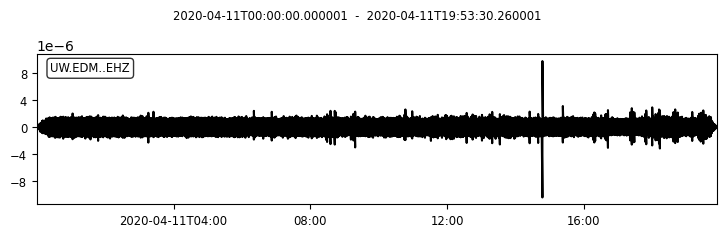

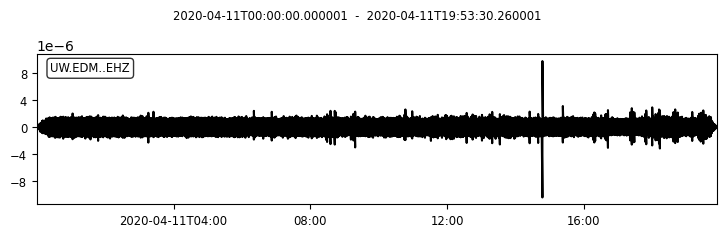

In [48]:
st_test_filt = st.copy()
st_test_filt[0].data = obspy.signal.filter.bandpass(st_test_filt[0], 1, pre_filt[2], st_test_filt[0].stats['sampling_rate'])
st_test_filt[0].plot()

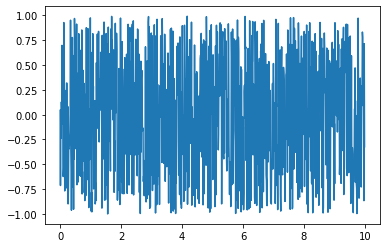

In [39]:
x = np.random.rand(int(1e3))*2-1
t = np.arange(0,10,0.01)
plt.plot(t,x)

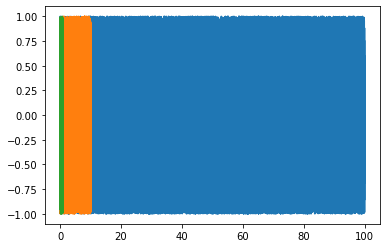

In [62]:
for i in [100,10,1]:
    x = np.random.rand(int(1e3*i))*2-1
    t = np.arange(0,1*i,0.001)
    plt.plot(t,x)

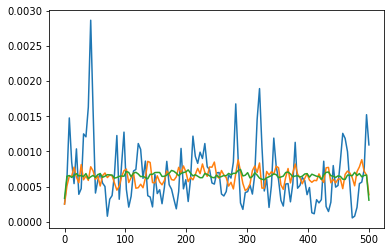

In [63]:
for i in [1,10,100]:
    x = np.random.rand(int(1e3*i))*2-1
    t = np.arange(0,10*i,0.01)
    Pxx, freqs = matplotlib.mlab.psd(x, Fs=1000) # PSD
    plt.plot(freqs, Pxx)

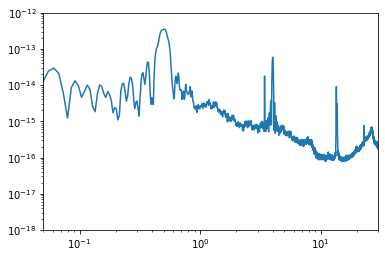

In [31]:
# 2**14 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(5e-2,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

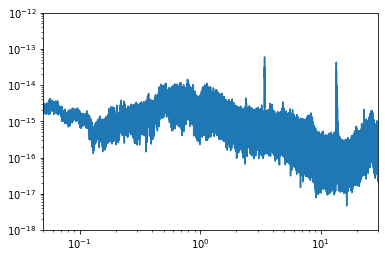

In [37]:
# 2**20 day instrument response removed
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(5e-2,3e1)
ax.set_ylim(1e-18,1e-12)
ax.set_xscale('log')
ax.set_yscale('log')

In [24]:
# calculate PSD and weight traces
# I do not need to weight because the PSD function already stacks, so calculate the mean between the windows

#initialize variables
npts_st = 0 # initialize variable
for tr in st:
    npts_st += tr.stats['npts'] # sum up the measurement points per day from all traces

Pxx_st = np.zeros(int(win_len/2+1)) # initialize array

# calculate psd for long enought traces and weight the trace depending on the length of the trace
for tr in st:
    if len(tr.data) >= win_len: # trace is as long or longer as window length
        try:
            Pxx, freqs = matplotlib.mlab.psd(tr.data, NFFT=win_len, noverlap=win_overlap, Fs=st[0].stats.sampling_rate) # PSD
            Pxx_weight = Pxx*(tr.stats['npts']/npts_st) # add a weight to trace depending on measurement points in tr
            Pxx_st += Pxx_weight # sum up the weighted power of all traces within a stream
            print(Pxx.shape, freqs.shape, Pxx_st.shape)
            
        except:
            print('Long trace, but problems during psd calculations: {}'. format(tr))
    else: # trace is shorter than window length
        print('Short trace: {}'. format(tr))

(8193,) (8193,) (8193,)
(8193,) (8193,) (8193,)


1355

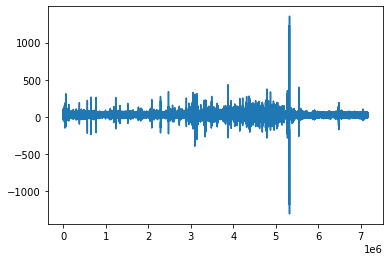

In [7]:
tr_Test = st_r[0].data.copy()
plt.plot(tr_Test)
max(tr_Test)

4.5220931784808436e-06

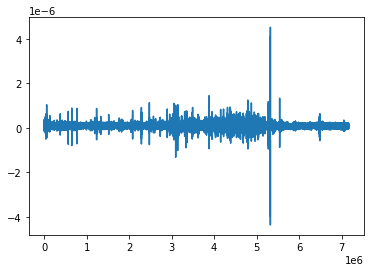

In [8]:
tr_TEST = tr_Test/2.9964E8
plt.plot(tr_TEST)
max(tr_TEST)

In [173]:
start_sec = np.arange(0, st[0].stats['npts'],
                  math.floor((st[0].stats['npts']*st[0].stats['delta'])/(win_len-win_overlap))) # start, stop, step

In [22]:
# start_points gives the number of the sample point for new window
start_points = np.arange(0, st[0].stats['npts']-(win_len-win_overlap), win_len-win_overlap) # start, stop, step
print(start_points, start_points.shape)

[      0   16384   32768   49152   65536   81920   98304  114688  131072
  147456  163840  180224  196608  212992  229376  245760  262144  278528
  294912  311296  327680  344064  360448  376832  393216  409600  425984
  442368  458752  475136  491520  507904  524288  540672  557056  573440
  589824  606208  622592  638976  655360  671744  688128  704512  720896
  737280  753664  770048  786432  802816  819200  835584  851968  868352
  884736  901120  917504  933888  950272  966656  983040  999424 1015808
 1032192 1048576 1064960 1081344 1097728 1114112 1130496 1146880 1163264
 1179648 1196032 1212416 1228800 1245184 1261568 1277952 1294336 1310720
 1327104 1343488 1359872 1376256 1392640 1409024 1425408 1441792 1458176
 1474560 1490944 1507328 1523712 1540096 1556480 1572864 1589248 1605632
 1622016 1638400 1654784 1671168 1687552 1703936 1720320 1736704 1753088
 1769472 1785856 1802240 1818624 1835008 1851392 1867776 1884160 1900544
 1916928 1933312 1949696 1966080 1982464 1998848 20

### calculate RMS, PGV, PGA

In [83]:
# possible with masked trace
tr_cut = st_cut[0].data
tr_rms = np.sqrt(np.mean(tr_cut**2))
tr_rmes = np.sqrt(np.median(tr_cut**2))
tr_pgv = max(abs(tr_cut))

tr_acc = (tr_cut.copy()[:-1] - tr_cut.copy()[1:]) /tr.stats['delta']
tr_pga = max(abs(tr_acc))

print(tr_rms, tr_rmes, tr_pgv, tr_pga)

2.001709301713603e-07 7.167999522121323e-08 1.4827143903006655e-06 0.000294241556281206


In [84]:
st_cut

1 Trace(s) in Stream:
UW.EDM..EHZ | 2020-04-11T19:53:18.080001Z - 2020-04-11T19:56:01.920001Z | 100.0 Hz, 16385 samples (masked)

In [ ]:
# initialise array for stream
for tr in st:
    # start_points gives the number of the sample point for new window
    start_points = np.arange(0, tr.stats['npts'], win_len-win_overlap) # start, stop, step
    print(start_points, start_points.shape)
    
    # initialise arrays for trace
    # initialise arrays for rms, rmes, pgv --> len(start_points)-1
    
    # initailise array for pga --> len(start_points)-2
    
    for s_point in range(len(start_points)-1):
        tr_cut = tr.data[start_points[s_point]:start_points[s_point+1]] # tr does not include the point at start_sec[1]
        tr_rms = np.sqrt(np.mean(tr_cut**2))
        tr_rmes = np.sqrt(np.median(tr_cut**2))
        tr_pgv = max(abs(tr_cut))
        
        tr_acc = (tr_cut.copy()[:-1] - tr_cut.copy()[1:]) /tr.stats['delta']
        tr_pga = max(abs(tr_acc_test))
        
        
    # write trace arrays in stream array
        

In [52]:
tr_test = st[0].data[start_points[0]:start_points[1]] # tr does not include the point at start_sec[1]
tr_test_rms = np.sqrt(np.mean(tr_test**2))
tr_test_pgv = max(abs(tr_test))
print(tr_test_rms,tr_test_pgv)

3.437216636132002e-08 1.9629062645941753e-07


In [60]:
tr_acc_test1 = tr_test.copy()[:-1]
tr_acc_test2 = tr_test.copy()[1:]
tr_acc_test_diff = tr_acc_test1-tr_acc_test2
tr_acc_test = tr_acc_test_diff/st[0].stats['delta'] # 'delta': 1/sampling_rate -> time in sec between points
tr_test_pga = max(abs(tr_acc_test))
print(tr_test_pga)

2.8401325464006055e-05


In [38]:
# start UTC times

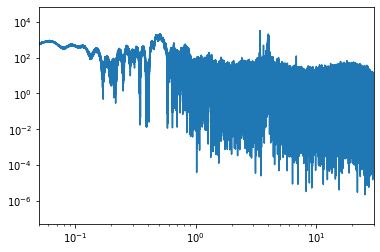

In [23]:
# 1 day taper 0.0045
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(5e-2,3e1)
ax.set_xscale('log')
ax.set_yscale('log')

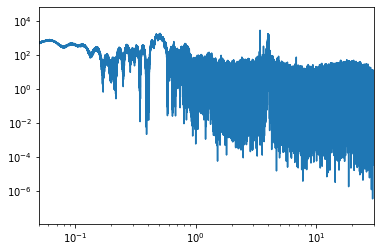

In [28]:
# 1 day taper 0.45
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(5e-2,3e1)
ax.set_xscale('log')
ax.set_yscale('log')

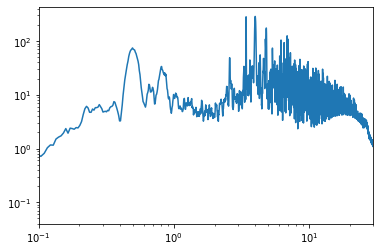

In [12]:
# 2**14 taper 0.0045
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(1e-1,3e1)
ax.set_xscale('log')
ax.set_yscale('log')

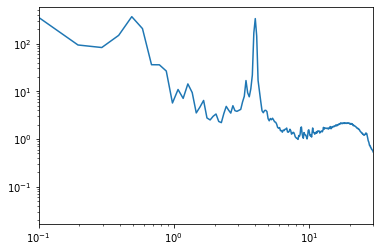

In [54]:
# 2**10 taper 0.45
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xlim(1e-1,3e1)
ax.set_xscale('log')
ax.set_yscale('log')

In [9]:
xx_arr = np.array([1,3,5,7])
xx_arr

array([1, 3, 5, 7])

In [10]:
test_npa = np.array([Pxx, freqs, xx_arr])
test_npa.shape

(3,)